# "HR has requested some help with a project," my team lead, Jordan, explained.

"They have data from a survey given to a bunch of managers, and they'd like you to go through it to find:
* the average salary for a software engineer for each currency,
* the average salary for a software engineer for each currency _grouped by age_, and
* a comparison of the four currencies which are most common in the data.

"And just a heads up: the data is a bit messy, since there are some free-response text fields in the survey, so it will need some cleaning. You'll also need to grab currency conversions to compare the salaries.

"They need the information by the end of the day."

"I'm on it!" I replied, and headed back to my desk to get started...

## My tasks
* Explore the dataset, handling missing entries
* Determine the salaries for software developers and engineers in USD
* Determine the average S/E salary for each currency and the average S/E salary for each currency based on age
* Visualize a comparison by plotting the salaries based on age for the top 4 currencies in the merged dataset

## Dependencies

In [1]:
# !conda install -c conda-forge thefuzz -y

In [2]:
# !conda install python-Levenshtein -y

In [3]:
# import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
# from thefuzz import fuzz, process

# Data preparation

## Read in the data

* I like to glance through the first few rows of the dataframe to get an idea for what I'm dealing with

In [4]:
df = pd.read_csv("../data301_proj1/data/Ask A Manager Salary Survey 2021 (Responses) - Form Responses 1.csv")
df.head()

,Timestamp,How old are you?,Industry,Job title,Additional context on job title,Annual salary,Other monetary comp,Currency,Currency - other,Additional context on income,Country,State,City,Overall years of professional experience,Years of experience in field,Highest level of education completed,Gender,Race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


## Initial feature filtering

* Not all the columns in the dataset are pertinent to the questions raised, so we'll filter out some.

In [5]:
pertinent_cols = [
    'Job title', "How old are you?",
    'Additional context on job title', 'Annual salary',
    'Other monetary comp', 'Currency',
    'Currency - other', 'Additional context on income',
    'Country','State', 'City'
]
df_pert = df[pertinent_cols].copy()

## Text cleaning

* A quick way to reduce cardinality of the 'Job title' text field is to lowercase all values

In [6]:
df_pert['Job title'] = df_pert['Job title'].map(lambda x: x.lower())

* Since this is a time-sensitive request, we'll create a simple Boolean flag with a rough filter of a few ways that people seem to have indicated their title. This will miss typos ('sotfware engineer' will be a 0) and allow non-software fields ('commercial real estate developer' will be a 1), but there's enough data and it captures enough of the actual tech roles to be a reasonable approximation. If precision was important, I would consider some regex and more complex filters.

In [7]:
df_pert["engineer_yn"] = df_pert["Job title"].apply(lambda x: 1 if "software" in x or "sw" in x or "developer" in x else 0)
df_pert["engineer_yn"].value_counts()

0    26014
1     1595
Name: engineer_yn, dtype: int64

* It looks as though we have roughly 1600 tech folks in our dataset, which should give us some worthwhile summary statistics. I'll sort and check for nulls as I continue the cleaning process.

In [8]:
df_pert.sort_values("engineer_yn", inplace=True)

In [9]:
df_pert.isnull().sum()

Job title                              0
How old are you?                       0
Additional context on job title    20463
Annual salary                          0
Other monetary comp                 7146
Currency                               0
Currency - other                   27427
Additional context on income       24603
Country                                0
State                               4911
City                                  75
engineer_yn                            0
dtype: int64

* Now I'll clean the 'Country' column, which unfortunately was a free text field (like 'Job title') instead of a dropdown list.

* I don't know a lot about the source of this data, but I do know that it was a US-based survey, so I expect to find a significant percentage of the respondents are from there

In [10]:
df_pert["Country"].value_counts()

United States      8844
USA                7847
US                 2572
Canada             1549
United States       652
                   ... 
europe                1
Can                   1
UNited States         1
Cayman Islands        1
the netherlands       1
Name: Country, Length: 364, dtype: int64

* Just like with 'Job title', we'll do a quick reduce by lowercasing all the country names, and we'll also strip any leading or trailing whitespace, then check the results.

In [11]:
df_pert["clean_country"] = df_pert["Country"].apply(lambda x: x.lower().strip())
df_pert["clean_country"].value_counts()

united states                                   9842
usa                                             8956
us                                              2734
canada                                          1656
uk                                               683
                                                ... 
y                                                  1
from new zealand but on projects across apac       1
california                                         1
australian                                         1
united kingdom.                                    1
Name: clean_country, Length: 250, dtype: int64

* I know there are WAY more elegant ways to do this (regex, in particular, or using fuzzy string matching/Levenshtein distance), but again, because of the time-sensitive nature of the request, I'll just brute-force it again, then check the results.

In [12]:
df_pert["clean_country"] = df_pert["clean_country"].apply(lambda x: "usa" if x == "us" or re.search('unit.+ sta.+', x) or "usa" in x or "u.s" in x or "u. s" in x else x)
df_pert["clean_country"].value_counts()

usa                22790
canada              1656
uk                   683
united kingdom       625
australia            382
                   ...  
y                      1
jamaica                1
méxico                 1
uganda                 1
united kingdom.        1
Name: clean_country, Length: 202, dtype: int64

* That looks closer to the numbers I was expecting based on what I know about the dataset.

* Next I'll filter out some additional columns out of which it would take too much time to extract useful information, then pull a dataset of only software engineers (using the Boolean flag from above).

In [13]:
desired_cols = [
    'Job title', "How old are you?",
    'Annual salary', 'Other monetary comp',
    'Currency', 'Currency - other',
    'Additional context on income', 'engineer_yn',
    'clean_country'
]
df_pert = df_pert[desired_cols]
df_se_only = df_pert[df_pert['engineer_yn'] == 1].copy()

* Since I'd like to do some calculations and also plot some of this information, I need to convert the 'Annual salary' field to a float (first removing the commas)

In [14]:
df_se_only["numeric salary"] = df_se_only["Annual salary"].apply(lambda x: float(re.sub(",", "", x)))

* The column 'Other monetary comp' is floats, but some are null, so I'll fill those with zeroes

In [15]:
df_se_only["Other monetary comp"] = df["Other monetary comp"].fillna(0)

* To simplify, I'll calculate a new column for total compensation, then remove the 'Annual salary' and 'Other monetary comp' columns.

In [16]:
df_se_only["total_comp"] = df_se_only["numeric salary"] + df_se_only["Other monetary comp"]
df_se_only.drop(["numeric salary", "Other monetary comp"], axis=1, inplace=True)

## Currency conversion

* I'll check the cardinality of the currency situation first.

In [17]:
df_se_only["Currency"].value_counts()

USD        1239
GBP         120
CAD          96
EUR          86
AUD/NZD      26
Other        17
CHF           7
SEK           4
Name: Currency, dtype: int64

* Since we have a limited set of currencies, it should be straightforward to convert them all to USD equivalents. With a quick Google search I found a currency conversion CSV to use, but there is a bit of work to be done to make it usable.

In [18]:
df_curr = pd.read_csv('preprocessing_and_eda/data/currency_converter.csv', header=1, nrows=42)

* The currency labels in the survey data need to be abbreviated to match the ones in the conversion CSV.

In [19]:
df_curr["Currency"] = df_curr["Currency"].apply(lambda x: "EUR" if "Euro" in str(x) else x)
df_curr["Currency"] = df_curr["Currency"].apply(lambda x: "USD" if "U.S." in str(x) else x)
df_curr["Currency"] = df_curr["Currency"].apply(lambda x: "CAD" if "Canadian" in str(x) else x)
df_curr["Currency"] = df_curr["Currency"].apply(lambda x: "GBP" if "U.K." in str(x) else x)
df_curr["Currency"] = df_curr["Currency"].apply(lambda x: "CHF" if "Swiss franc" in str(x) else x)
df_curr["Currency"] = df_curr["Currency"].apply(lambda x: "SEK" if "Swedish" in str(x) else x)
df_curr["Currency"] = df_curr["Currency"].apply(lambda x: "AUD/NZD" if "Australian" in str(x) or "Zealand" in str(x) else x)

* January 10 is the closest date in the currency conversion dataset to the date of the survey, so I'll filter out all but that column.

In [20]:
df_curr_conv = df_curr[["Currency", "10-Jan-22"]]

currencies = ["EUR", "USD", "CAD", "GBP", "CHF", "SEK", "AUD/NZD"]
df_app_curr = df_curr_conv[df_curr_conv["Currency"].isin(currencies)].copy()
df_app_curr.reset_index()

,index,Currency,10-Jan-22
0,1,EUR,1.1318
1,3,GBP,1.35835
2,4,USD,1
3,6,AUD/NZD,0.7193
4,10,CAD,1.2679
5,22,AUD/NZD,0.6777
6,33,SEK,9.0935
7,34,CHF,0.92195


* Since Australia and New Zealand are grouped in our survey data, I'll just use the AUD and drop NZD

In [21]:
df_app_curr.drop([22], inplace=True)

* I'll save the clean currency conversion dataset as a csv for safekeeping...

In [22]:
df_app_curr.to_csv("preprocessing_and_eda/data/curr_conv.csv")

* ...and read it back in so I can start my notebook here when I come back to it later

In [23]:
df_curr_conv = pd.read_csv("preprocessing_and_eda/data/curr_conv.csv")

* Now I'll join (in pandas: `.merge()`) the software engineer dataframe with the currency converter and calculate the total compensation in USD

In [24]:
df_merged = df_se_only.merge(df_curr_conv, on="Currency")
df_merged_copy = df_merged.copy()
df_merged["total_comp_usd"] = round(df_merged_copy["total_comp"] / df_merged_copy["10-Jan-22"], 2)

* For the final clean, prepared dataset, we only need the job title, age, original currency (and country, in case it's of interest), and the total compensation in USD.

In [25]:
df_final = df_merged[["Job title", "How old are you?", "Currency", "clean_country", "total_comp_usd"]].copy()

## Removing outliers

* To check for outliers, I'll sort the list by total compensation.

In [26]:
df_final.sort_values("total_comp_usd", inplace=True)
df_final.reset_index()

,index,Job title,How old are you?,Currency,clean_country,total_comp_usd
0,1510,software developer,25-34,EUR,germany,48.6
1,1474,senior developer / consultant,35-44,EUR,germany,64.5
2,384,msw,55-64,USD,usa,78.0
3,520,software engineer,25-34,USD,usa,145.0
4,429,ios developer,25-34,USD,pakistan,7250.0
...,...,...,...,...,...,...
1573,1091,"director, software development",35-44,USD,usa,950000.0
1574,889,software development manager,35-44,USD,usa,1100000.0
1575,1052,software engineer,25-34,USD,usa,1100000.0
1576,565,senior staff software engineer,45-54,USD,usa,1287000.0


* It looked as though there are some outliers on the low end. It's possible that those respondents simply indicated their salary in thousands, but since I don't know (and there are only 4 that seem out of place), I'll simply remove them.

In [27]:
df_final = df_final[df_final['total_comp_usd'] > 5000]

* Again, I'll write the cleaned dataset to a CSV for safekeeping, then read from there to plant another checkpoint for the notebook.

In [28]:
df_final.to_csv('preprocessing_and_eda/data/clean_dataset.csv', index=False)

In [29]:
df_final = pd.read_csv('preprocessing_and_eda/data/clean_dataset.csv')

# EDA and insights!

## Average compensation, grouped by currency

* Using a pandas `groupby()` is similar to a `GROUP BY` clause in SQL; requesting the mean of a groupby object is like selecting the average and grouping by the desired feature.

In [30]:
means = df_final.groupby(['Currency']).mean()
means.sort_values('total_comp_usd', ascending=False, inplace=True)

* For legibility, I'll list the compensation in the standard $x.xx format.

In [31]:
means['total_comp_usd'] = means['total_comp_usd'].apply(lambda x: round(x, 2))

* In case I want easy reference to those mean salaries later, I'll save them to a csv.

In [32]:
means.to_csv('preprocessing_and_eda/insights/avg_comp_by_currency.csv')

## Average compensation, grouped by currency and broken out by age range of the developer

* A `.groupby()` on multiple columns will return a hierarchically-indexed DataFrame, which can then be sorted by those columns.

In [33]:
means_by_age = df_final.groupby(["Currency", 'How old are you?']).mean()
# means_by_age.head()
means_by_age.sort_values(['Currency', 'How old are you?'], ascending=True, inplace=True)

In [34]:
means_by_age.to_csv('preprocessing_and_eda/insights/avg_comp_by_currency_by_age.csv')

## Visualization: salaries, grouped by age, for the top four currencies in the merged dataset

* N.B.: I verified with our HR contact person that "top four" means "four most commonly represented," NOT "four with the highest average compensation"

* For the sake of plotting, I'll clean up the means_by_age DataFrame.

In [35]:
means_by_age.reset_index(inplace=True)

* To determine the top four currencies, I'll get the `.value_counts()` for the earlier DataFrame

In [36]:
df_final['Currency'].value_counts()

USD        1237
GBP         120
CAD          96
EUR          84
AUD/NZD      26
CHF           7
SEK           4
Name: Currency, dtype: int64

* The four currencies of interest are USD (United States), GBP (UK), CAD (Canada), and EUR (Europe). I'll filter out of the means_by_age DataFrame any currencies not in that list.

In [37]:
four_currs = ['USD', 'GBP', 'CAD', 'EUR']

top_four = means_by_age.loc[lambda df: df['Currency'].isin(four_currs), :]

* Lastly I'll plot the information, highlighting the significantly higher salaries for software engineers paid in USD

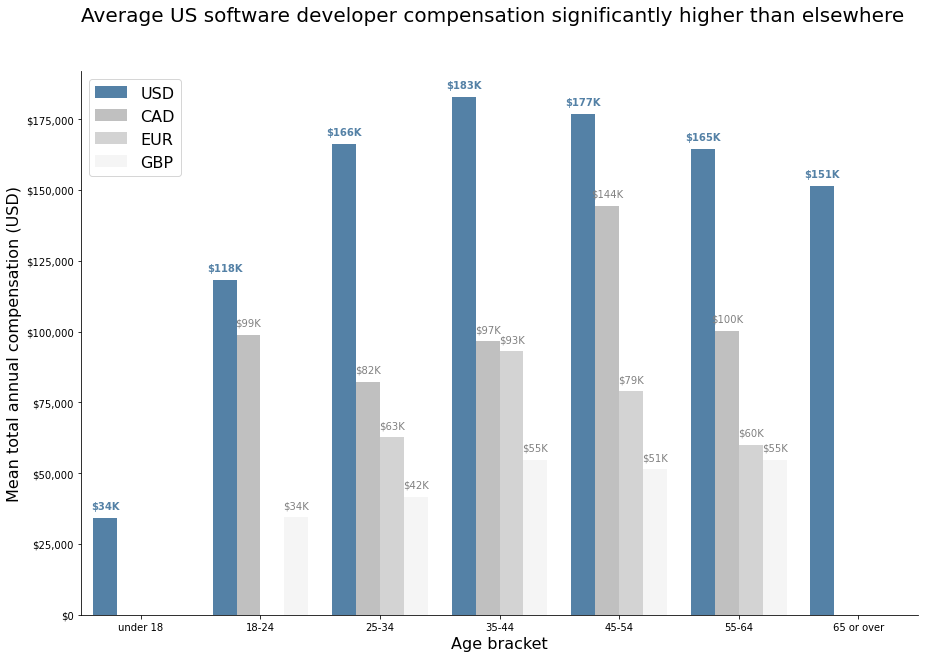

In [40]:
plt.figure(figsize=(15, 10))

splot = sns.barplot(
    data=top_four,
    x="How old are you?",
    order=['under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65 or over'],
    y="total_comp_usd",
    hue="Currency",
    hue_order=['USD', 'CAD', 'EUR', 'GBP'],
    palette=['steelblue', 'silver', 'lightgrey', 'whitesmoke']
)
plt.ylabel("Mean total annual compensation (USD)", size=16)
plt.xlabel("Age bracket", size=16)
plt.title("Average US software developer compensation significantly higher than elsewhere", loc='left', size=20, pad=50)
splot.yaxis.set_major_formatter('${x:,.0f}')
sns.despine()

# bold text for only the USD annotations
usd_color = (0.32843137254901955, 0.5049019607843136, 0.6519607843137256, 1.0)
for i, p in enumerate(splot.patches, 1):
    bar_color = p.get_facecolor()
    if pd.isna(p.get_height()):
        continue
    elif bar_color == usd_color:
        splot.annotate('$' + format(round(p.get_height()/1000), '.0f')+"K",
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       size=10,
                       fontweight='extra bold',
                       color=bar_color,
                       xytext = (0, 12),
                       textcoords = 'offset points')
    else:
        splot.annotate('$' + format(round(p.get_height()/1000), '.0f')+"K",
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       size=10,
                       color='grey',
                       xytext = (0, 12),
                       textcoords = 'offset points')
_ = plt.legend(loc='upper left', fontsize=16)
plt.savefig('preprocessing_and_eda/insights/compensation_visual.png')